# Chapter Two. Fraud detection using labelled data
Now that you're familiar with the main challenges of fraud detection, you're about to learn how to flag fraudulent transactions with supervised learning. You will use classifiers, adjust them and compare them to find the most efficient fraud detection model.

> **Topics:**
- 1. Review of classification methods
    - 1.1. Natural hit rate
    - 1.2. Random Forest Classifier
- 2. Performance evaluation
    - 2.1. Performance metrics for the RF model
    - 2.2. Plotting the Precision Recall Curve
- 3. Adjusting your algorithm weights
    - 3.1. Model adjustments
    - 3.2. Adjusting your Random Forest to fraud detection
    - 3.3. GridSearchCV to find optimal parameters
    - 3.4. Model results using GridSearchCV
- 4. Ensemble methods
    - 4.1. Logistic Regression
    - 4.2. Voting Classifier
    - 4.3. Adjust weights within the Voting Classifier

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

filepath = '../_datasets/chapter_2/'

sns.set()

## 1. Review of classification methods for fraud detection

### What is classification?
**Goal of classification**: Use known fraud cases to train a model to recognise new fraud cases
Examples:
- Email Spam/Not spam
- Transaction online fraudulent Yes/No
- Tumor Malignant/Benign?

Variable to predict: $y ∈ 0, 1$
- 0: Negative class ("majority" normal cases)
- 1: Positive class ("minority" fraud cases)

### Classification methods commonly used for fraud detection

#### Logistic regresion
> Works reasonably well on highly imbalaced data. Quite usefull for fraud detection

![][06-Logistic_Regression]

#### Neural Network

![][07-Neural_Network]

#### Decision trees 
> Gives very transparent results that are easily interpreted by fraud analysts. Nonetheless, ***they are prone to overfit your data***

![][08-Decision_trees]

#### Random forest: 
> Construct a multitude of decision trees when training your model and outputting the class that is the **mode** or **mean** predicted class of all the individual trees. To be more precise, ***a random forest consists of a collection of trees on a random subset of features***. Final predictions are the combined results of those trees. Random forest can handle complex data, and ***are not prone to overfit***. They are interpretable by looking at feature importance, and **can be adjusted to work well on highly imbalanced data**. The only drawback is that they can be computationally quite heavy to run. Nonetheless, **random forest are very popular for fraud detection**.

![][09-Random_Forests]

```Python
    from sklearn.ensemble import RandomForestClassifier
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    print (metrics.accuracy_score(y_test, predicted))
```

[06-Logistic_Regression]:_Docs/06-Logistic_Regression.png
[07-Neural_Network]:_Docs/07-Neural_Network.png
[08-Decision_trees]:_Docs/08-Decision_trees.png
[09-Random_Forests]:_Docs/09-Random_Forests.png

### 1.1 Natural hit rate
In this exercise, you'll again use credit card transaction data. The features and labels are similar to the data in the previous chapter, and the **data is heavily imbalanced**. We've given you features `X` and labels `y` to work with already, which are both `numpy` arrays.

First you need to explore how prevalent fraud is in the dataset, to understand what the **"natural accuracy"** is, if we were to predict everything as non-fraud. It's is important to understand which level of "accuracy" you need to "beat" in order to get a **better prediction than by doing nothing**. In the following exercises, you'll create our first random forest classifier for fraud detection. That will serve as the **"baseline"** model that you're going to try to improve in the upcoming exercises.

In [2]:
# Import pandas and read csv
import pandas as pd
df = pd.read_csv(filepath+"creditcard_sampledata_2.csv")

df.head()

,Unnamed: 0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,221547,-1.191668,0.428409,1.640028,-1.848859,-0.870903,-0.204849,-0.385675,0.352793,-1.098301,...,0.507173,1.292565,-0.467752,1.244887,0.697707,0.059375,-0.319964,-0.017444,27.44,0
1,184524,1.966614,-0.450087,-1.228586,0.142873,-0.150627,-0.543590,-0.076217,-0.108390,0.973310,...,0.124055,0.564916,-0.039331,-0.283904,0.186400,0.192932,-0.039155,-0.071314,35.95,0
2,91201,1.528452,-1.296191,-0.890677,-2.504028,0.803202,3.350793,-1.633016,0.815350,-1.884692,...,-0.412088,-1.017485,0.129566,0.948048,0.287826,-0.396592,0.042997,0.025853,28.40,0
3,26115,-0.774614,1.100916,0.679080,1.034016,0.168633,0.874582,0.209454,0.770550,-0.558106,...,0.011158,0.146017,-0.130401,-0.848815,0.005698,-0.183295,0.282940,0.123856,43.20,0
4,201292,-1.075860,1.361160,1.496972,2.242604,1.314751,0.272787,1.005246,0.132932,-1.558317,...,0.254485,0.530692,-0.651119,0.626389,1.040212,0.249501,-0.146745,0.029714,10.59,0


In [8]:
# Define a function to select features array and label array
def prep_data(df, idx_column_start = 2, idx_column_end = 30, class_column_name = 'Class'):
    X = df.loc[:,df.columns[idx_column_start:idx_column_end]].values
    y = df.loc[:,class_column_name].values
    return X, y

# Define a function to create a scatter plot of our data and labels
def plot_data(X, y, figsize=(12,6)):
    plt.figure(figsize=figsize)
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class #0", alpha=0.5, linewidth=0.15)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class #1", alpha=0.5, linewidth=0.15, c='r')
    plt.legend()

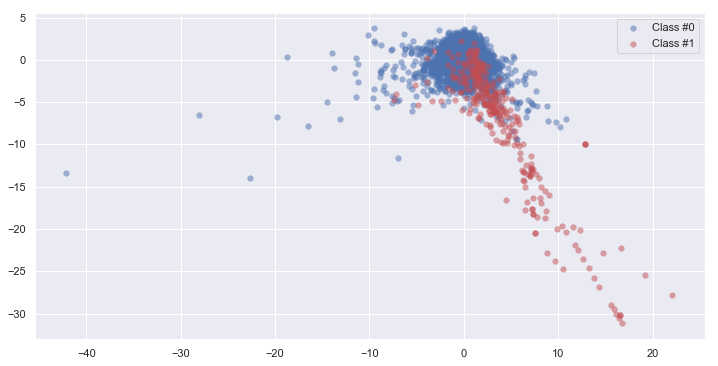

In [10]:
# Create X and y from the prep_data function 
X,y = prep_data(df)

# Plot our data by running our plot data function on X and y
plot_data(X, y)

In [12]:
# Count the total number of observations from the length of y
total_obs = len(y)

# Count the total number of non-fraudulent observations 
non_fraud = [i for i in y if i == 0]
count_non_fraud = non_fraud.count(0)

# Calculate the percentage of non fraud observations in the dataset
percentage = (float(count_non_fraud)/float(total_obs)) * 100

# Print the percentage: this is our "natural accuracy" by doing nothing
print("natural accuracy: ",percentage)

natural accuracy:  95.8904109589041


This tells us that by doing nothing, we would be correct in 95.9% of the cases. So now you understand, that **if we get an accuracy of less than this number, our model does not actually add any value in predicting how many cases are correct**. Let's see how a random forest does in predicting fraud in our data.

### 1.2 Random Forest Classifier
Let's now create a first random forest classifier for fraud detection. Hopefully you can do better than the baseline accuracy you've just calculated, which was roughly **96%**. This model will serve as the **"baseline" model** that you're going to try to improve in the upcoming exercises. Let's start first with **splitting the data into a test and training set**, and **defining the Random Forest model**. The data available are features `X` and labels `y`.

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split 
# Import the random forest model from sklearn
from sklearn.ensemble import RandomForestClassifier

# Split your data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Define the model as the random forest
model = RandomForestClassifier(random_state=5)

# Fit the model to our training set
model.fit(X_train, y_train)

# Obtain predictions from the test data 
predicted = model.predict(X_test)

# Print the accuracy performance metric
print(accuracy_score(y_test, predicted))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9904109589041096


**Question**
What is a benefit of using Random Forests versus Decision Trees?

**Possible Answers**
- [ ] Random Forests always have a higher accuracy than Decision Trees.
- [x] Random Forests do not tend to overfit, whereas Decision Trees do.
- [ ] Random Forests are computationally more efficient than Decision Trees.
- [ ] You can obtain "feature importance" from Random Forest, which makes it more transparent.

Random Forest prevents overfitting most of the time, by creating random subsets of the features and building smaller trees using these subsets. Afterwards, it combines the subtrees of subsamples of features, so it does not tend to overfit to your entire feature set the way "deep" Decisions Trees do.

## 2. Measuring fraud detection performance

### Accuracy isn't everything
Throw accuracy out of the window when working on fraud detection problems

![][Accuracy]

### False positives, false negatives and actual fraud caught

![][11-confusion_matrix]

***Depending on the business case, one migth care more about false negatives than false positives or viceversa***

> **A credit card company** migth want to catch as much fraud as possible and **reduce false negatives**, as fraudulent transactions can be incredibly costly, whereas a false alarm just means someones transaction is blocked. **The credit card company therefore want to optimize for *recall***.

> **An insurance company** can't handle many false alarms, as it means getting a team of investigators involved for each positive prediction. **The insurance company cares more for *precision***

### Precision Recall trade-off

> **Precision**: Is the fraction of actual fraud cases out of "all predicted" fraud cases.

> **Recall**: Is the fraction of the predicted fraud cases out of "actual" fraud cases

> **F-score or F-measure**: weighs both precision and recall into one measure.

![][12-metrics]

### Obtaining performance metrics
```Python
    # Import the packages
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import average_precision_score
    # Calculate average precision and the PR curve
    average_precision = average_precision_score(y_test, predicted)
    # Obtain precision and recall
    precision, recall, _ = precision_recall_curve(y_test, predicted)
```

### Precision-Recall Curve

![][13-Precision-Recall_Curve]

### ROC curve to compare algorithms
![][14-ROC_Curve]

```Python
    # Obtain model probabilities
    probs = model.predict_proba(X_test)
    # Print ROC_AUC score using probabilities
    print(metrics.roc_auc_score(y_test, probs[:, 1]))
```

### Confusion matrix and classification report

```Python
    from sklearn.metrics import classification_report, confusion_matrix
    
    # Obtain predictions
    predicted = model.predict(X_test)
    
    # Print classification report using predictions
    print(classification_report(y_test, predicted))
    
    # Print confusion matrix using predictions
    print(confusion_matrix(y_test, predicted))
```

[Accuracy]:_Docs/10-Accuracy.png
[11-confusion_matrix]:_Docs/11-confusion_matrix.png
[12-metrics]:_Docs/12-metrics.png
[13-Precision-Recall_Curve]:_Docs/13-Precision-Recall_Curve.png
[14-ROC_Curve]:_Docs/14-ROC_Curve.png

### 2.1 Performance metrics for the RF model
In the previous exercises you obtained an accuracy score for your random forest model. This time, we know **accuracy can be misleading** in the case of fraud detection. With highly imbalanced fraud data, the ***AUROC curve is a more reliable performance metric***, used to compare different classifiers. Moreover, the ***classification report*** tells you about the precision and recall of your model, whilst the ***confusion matrix*** actually shows how many fraud cases you can predict correctly. So let's get these performance metrics.

You'll continue working on the same random forest model from the previous exercise. Your model, defined as `model = RandomForestClassifier(random_state=5)` has been fitted to your training data already, and `X_train`, `y_train`, `X_test`, `y_test` are available.

In [17]:
# Import the packages to get the different performance metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Obtain the predictions from our random forest model 
predicted = model.predict(X_test)

# Predict probabilities
probs = model.predict_proba(X_test)

# Print the ROC curve, classification report and confusion matrix
print(roc_auc_score(y_test, probs[:,1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

0.9338879319822626
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.96      0.80      0.87        91

   micro avg       0.99      0.99      0.99      2190
   macro avg       0.98      0.90      0.93      2190
weighted avg       0.99      0.99      0.99      2190

[[2096    3]
 [  18   73]]


You have now obtained more meaningful performance metrics that tell us how well the model performs, given the highly imbalanced data that you're working with. **The model predicts 76 cases of fraud, out of which 73 are actual fraud**. You have only **3 false positives**. This is really good, and as a result you have a very high precision score. **You do however, don't catch 18 cases of actual fraud**. Recall is therefore not as good as precision. Let's try to improve that in the following exercises.

### 2.2 Plotting the Precision Recall Curve
You can also plot a **Precision-Recall curve**, to investigate the trade-off between the two in your model. In this curve **Precision and Recall are inversely related**; as Precision increases, Recall falls and vice-versa. ***A balance between these two needs to be achieved in your model, otherwise you might end up with many false positives, or not enough actual fraud cases caught***. To achieve this and to compare performance, the **precision-recall curves** come in handy.

Your Random Forest Classifier is available as `model`, and the predictions as `predicted`. You can simply obtain the average precision score and the PR curve from the sklearn package. The function `plot_pr_curve()` plots the results for you. Let's give it a try.

In [22]:
# Import the packages to get the different performance metrics
from sklearn.metrics import average_precision_score, precision_recall_curve

# Calculate average precision and the PR curve
average_precision = average_precision_score(y_test, predicted)

# Obtain precision and recall 
precision, recall, _ = precision_recall_curve(y_test, predicted)

array([1.       , 0.8021978, 0.       ])

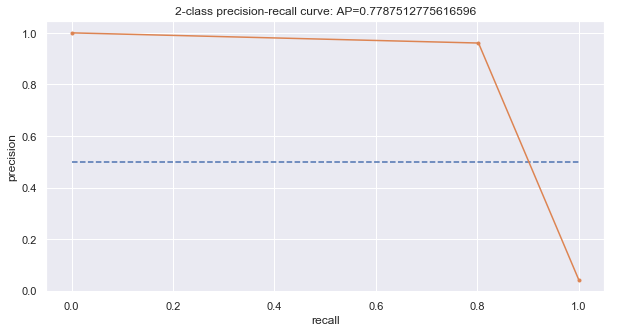

In [31]:
plt.figure(figsize=(10,5))

plt.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the precision-recall curve for the model
plt.plot(recall, precision, marker='.')
plt.xlabel('recall')
plt.ylabel('precision')
plt.title('2-class precision-recall curve: AP={}'.format(average_precision))
plt.show()

**Question**
What's the benefit of the performance metric ROC curve (AUROC) versus Precision and Recall?

**Possible Answers**
- [x] The AUROC answers the question: "How well can this classifier be expected to perform in general, at a variety of different baseline probabilities?" but precision and recall don't.
> ***Correct: The ROC curve plots the true positives vs. false positives , for a classifier, as its discrimination threshold is varied. Since, a random method describes a horizontal curve through the unit interval, it has an AUC of 0.5. Minimally, classifiers should perform better than this, and the extent to which they score higher than one another (meaning the area under the ROC curve is larger), they have better expected performance.***
- [ ] The AUROC answers the question: "How meaningful is a positive result from my classifier given the baseline probabilities of my problem?" but precision and recall don't.
> **Incorrect**: This is what Precision and Recall are specifically good at indicating, the AUROC is the probability that a random positive sample will have a higher score than a random negative sample.
- [ ] Precision and Recall are not informative when the data is imbalanced.
> **Incorrect**: you especially want to use Precision and Recall when dat is highly imbalanced, and is more informative than the ROC curve in that situation.
- [ ] The AUROC curve allows you to visualize classifier performance and with Precision and Recall you cannot.
> **Incorrect**: you especially want to use Precision and Recall when dat is highly imbalanced, and is more informative than the ROC curve in that situation.

## 3.Adjusting your algorithms for fraud detection

### Balanced weights

> ***balanced*** mode: user the values of **$y$** to automatically adjust weights inversely proportional to class frequencies in the input data. This option is available for many others classifiers.

> ***balanced_subsample*** mode: is the same as the "balanced" option, except that weights are calculated again in each iteration of growing a tree in the random forest. This option is only applicable for the Ramdom Forest model.

```Python
model = RandomForestClassifier(class_weight='balanced')
model = RandomForestClassifier(class_weight='balanced_subsample')
model = LogisticRegression(class_weight='balanced')
model = SVC(kernel='linear', class_weight='balanced', probability=True)
```

### Hyperparameter tuning for fraud detection
```Python
model = RandomForestClassifier(class_weight={0:1,1:4},random_state=1)
model = LogisticRegression(class_weight={0:1,1:4}, random_state=1)
```
```Python
model = RandomForestClassifier( n_estimators=10,
                                criterion=’gini’,
                                max_depth=None,
                                min_samples_split=2,
                                min_samples_leaf=1,
                                max_features=’auto’,
                                n_jobs=-1, class_weight=None)
```

### Using GridSearchCV
```Python
from sklearn.model_selection import GridSearchCV

# Create the parameter grid
param_grid = {
'max_depth': [80, 90, 100, 110],
'max_features': [2, 3],
'min_samples_leaf': [3, 4, 5],
'min_samples_split': [8, 10, 12],
'n_estimators': [100, 200, 300, 1000]
}

# Define which model to use
model = RandomForestRegressor()
```

> Defining a **scoring** metric to evaluate models on is incredibly important in fraud detection, the default option for this parameter would be ***accuracy***, and this metric is useless for imabalanced data, aka fraud detection. Therefore you need to pass ***precision***,***recall*** or ***f1***

```Python
# Instantiate the grid search model
grid_search_model = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5, n_jobs = -1, scoring='f1')
```

### Finding the best model with GridSearchCV
```Python
Fit the grid search to the data
grid_search_model.fit(X_train, y_train)

# Get the optimal parameters
grid_search_model.best_params_
{'bootstrap': True,
'max_depth': 80,
'max_features': 3,
'min_samples_leaf': 5,
'min_samples_split': 12,
'n_estimators': 100}

# Get the best_estimator results
grid_search.best_estimator_
grid_search.best_score_
```

### 3.1 Model adjustments
A simple way to adjust the random forest model to deal with highly imbalanced fraud data, is to use the **`class_weights` option** when defining your `sklearn` model. However, as you will see, it is a bit of a blunt force mechanism and might not work for your very special case.

In this exercise you'll explore the `weight = "balanced_subsample"` mode the Random Forest model from the earlier exercise. You already have split your data in a training and test set, i.e `X_train`, `X_test`, `y_train`, `y_test` are available. The metrics function have already been imported.

In [33]:
# Define the model with balanced subsample
model = RandomForestClassifier(class_weight='balanced_subsample', random_state=5)

# Fit your training model to your training set
model.fit(X_train, y_train)

# Obtain the predicted values and probabilities from the model 
predicted = model.predict(X_test)
probs = model.predict_proba(X_test)

# Print the roc_auc_score, the classification report and confusion matrix
print(roc_auc_score(y_test, probs[:,1]))
print(classification_report(y_test, predicted))
print(confusion_matrix(y_test, predicted))

0.9347962661445273
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.99      0.79      0.88        91

   micro avg       0.99      0.99      0.99      2190
   macro avg       0.99      0.90      0.94      2190
weighted avg       0.99      0.99      0.99      2190

[[2098    1]
 [  19   72]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


You can see that the model results don't improve drastically. We now have 3 less false positives, but now **19 in stead of 18 false negatives**, i.e. cases of fraud we are not catching. **If we mostly care about catching fraud, and not so much about the false positives, this does actually not improve our model at all**, albeit a simple option to try. In the next exercises you'll see how to more smartly tweak your model to focus on reducing false negatives and catch more fraud.

### 3.2 Adjusting your Random Forest to fraud detection
In this exercise you're going to dive into the options for the random forest classifier, as we'll **assign weights** and **tweak the shape** of the decision trees in the forest. You'll **define weights manually**, to be able to off-set that imbalance slightly. In our case we have 300 fraud to 7000 non-fraud cases, so by setting the weight ratio to 1:12, we get to a 1/3 fraud to 2/3 non-fraud ratio, which is good enough for training the model on.

The data in this exercise has already been split into training and test set, so you just need to focus on defining your model. You can then use the function `get_model_results()` as a short cut. This function fits the model to your training data, predicts and obtains performance metrics similar to the steps you did in the previous exercises.

In [38]:
def get_model_results(X_train, y_train, X_test, y_test, model):
    # Fit your training model to your training set
    model.fit(X_train, y_train)

    # Obtain the predicted values and probabilities from the model 
    predicted = model.predict(X_test)
    probs = model.predict_proba(X_test)

    # Print the roc_auc_score, the classification report and confusion matrix
    rocAucScore = (roc_auc_score(y_test, probs[:,1]))
    classificationReport = (classification_report(y_test, predicted))
    confusionMatrix = (confusion_matrix(y_test, predicted))
    
    return rocAucScore, classificationReport, confusionMatrix

In [40]:
# Change the model options
model = RandomForestClassifier(bootstrap=True, class_weight={0:1, 1:12}, criterion='entropy',			
			# Change depth of model
            max_depth=10,
			# Change the number of samples in leaf nodes
            min_samples_leaf=10, 
			# Change the number of trees to use
            n_estimators=20, n_jobs=-1, random_state=5)

# Run the function get_model_results
rocAucScore, classificationReport, confusionMatrix = get_model_results(X_train, y_train, X_test, y_test, model)
print(rocAucScore)
print(classificationReport)
print(confusionMatrix)

0.9609651901219315
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.97      0.85      0.91        91

   micro avg       0.99      0.99      0.99      2190
   macro avg       0.98      0.92      0.95      2190
weighted avg       0.99      0.99      0.99      2190

[[2097    2]
 [  14   77]]


ou can see by smartly defining more options in the model, you can obtain better predictions. **You have effectively reduced the number of false negatives**, i.e. you are catching more cases of fraud, whilst keeping the number of false positives low. In this exercise you've manually changed the options of the model. There is a smarter way of doing it, by using **GridSearchCV**, which you'll see in the next exercise!

### 3.3 GridSearchCV to find optimal parameters
In this exercise you're going to **tweak our model in a less "random" way**, but use `GridSearchCV` to do the work for you.

With `GridSearchCV` you can define **which performance metric to score** the options on. Since for fraud detection we are mostly interested in catching as many fraud cases as possible, you can optimize your model settings to get the best possible Recall score. If you also cared about reducing the number of false positives, you could optimize on F1-score, this gives you that nice Precision-Recall trade-off.

`GridSearchCV` has already been imported from `sklearn.model_selection`, so let's give it a try!

In [44]:
from sklearn.model_selection import GridSearchCV

# Define the parameter sets to test
param_grid = {'n_estimators': [1, 30], 
              'max_features': ['auto', 'log2'],  
              'max_depth': [4, 8, 10], 
              'criterion': ['gini', 'entropy']
             }

# Define the model to use
model = RandomForestClassifier(random_state=5)

# Combine the parameter sets with the defined model
CV_model = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='recall', n_jobs=-1)

# Fit the model to our training data and obtain best parameters
CV_model.fit(X_train, y_train)
CV_model.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 30}

### 3.4 Model results using GridSearchCV
You discovered that the **best parameters for your model** are that the ***split criterion*** should be set to 'gini', the ***number of estimators*** (trees) should be 30, the ***maximum depth*** of the model should be 8 and the ***maximum features*** should be set to "log2".

Let's give this a try and see how well our model performs. You can use the `get_model_results()` function again to save time.

In [45]:
# Input the optimal parameters in the model
model = RandomForestClassifier(class_weight={0:1,1:12}, 
                               criterion='gini',
                               max_depth=8, 
                               max_features='log2',
                               min_samples_leaf=10,
                               n_estimators=30,
                               n_jobs=-1,
                               random_state=5)

# Run the function get_model_results
rocAucScore, classificationReport, confusionMatrix = get_model_results(X_train, y_train, X_test, y_test, model)
print(rocAucScore)
print(classificationReport)
print(confusionMatrix)

0.9749697658225529
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.95      0.84      0.89        91

   micro avg       0.99      0.99      0.99      2190
   macro avg       0.97      0.92      0.94      2190
weighted avg       0.99      0.99      0.99      2190

[[2095    4]
 [  15   76]]


You've managed to improve your model even further. The number of false positives has now been slightly reduced even further, which means we are catching more cases of fraud. However, you see that the number of false positives actually went up. That is that Precision-Recall trade-off in action. To decide which final model is best, you need to take into account how bad it is not to catch fraudsters, versus how many false positives the fraud analytics team can deal with. Ultimately, this final decision should be made by you and the fraud team together.

## 4. Using ensemble methods to improve fraud detection

### What are Ensemble Methods: Bagging versus Stacking

![][15-Ensemble_Methods]

### Stacking Ensemble Methods

![][16-Stacking]

### Why use ensemble methods for fraud detection
Ensemble methods:
- Are robust
- Can help you avoid overfitting
- Can typically improve prediction performance
- Are a winning formula at prestigious Kaggle competitions

### Voting Classifier
```Python
from sklearn.ensemble import VotingClassifier
clf1 = LogisticRegression(random_state=1)
clf2 = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='hard')
ensemble_model.fit(X_train, y_train)
ensemble_model.predict(X_test)
VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft', weights=[2,1,1])
```

[15-Ensemble_Methods]:_Docs/15-Ensemble_Methods.png
[16-Stacking]:_Docs/16-Stacking.png

### 4.1 Logistic Regression
In this last lesson you'll **combine three algorithms** into one model with the **VotingClassifier**. This allows us to benefit from the different aspects from all models, and hopefully improve overall performance and detect more fraud. The first model, the Logistic Regression, has a slightly higher recall score than our optimal Random Forest model, but gives a lot more false positives. You'll also add a Decision Tree with balanced weights to it. The data is already split into a training and test set, i.e. `X_train`, `y_train`, `X_test`, `y_test` are available.

In order to understand how the Voting Classifier can potentially improve your original model, you should check the standalone results of the Logistic Regression model first.

In [49]:
from sklearn.linear_model import LogisticRegression

# Define the Logistic Regression model with weights
model = LogisticRegression(class_weight={0:1, 1:15}, random_state=5)

# Get the model results

rocAucScore, classificationReport, confusionMatrix = get_model_results(X_train, y_train, X_test, y_test, model)
print(rocAucScore)
print(classificationReport)
print(confusionMatrix)

0.9722054981702433
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      2099
           1       0.63      0.88      0.73        91

   micro avg       0.97      0.97      0.97      2190
   macro avg       0.81      0.93      0.86      2190
weighted avg       0.98      0.97      0.98      2190

[[2052   47]
 [  11   80]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


As you can see the Logistic Regression has quite different performance from the Random Forest. More false positives, but also a better Recall. It will therefore will a useful addition to the Random Forest in an ensemble model. Let's give that a try

### 4.2 Voting Classifier
Let's now **combine three machine learning models into one**, to improve our Random Forest fraud detection model from before. You'll combine our usual Random Forest model, with the Logistic Regression from the previous exercise, with a simple Decision Tree. You can use the short cut `get_model_results()` to see the immediate result of the ensemble model.

In [56]:
def get_model_results_2(X_train, y_train, X_test, y_test, model):
    # Fit your training model to your training set
    model.fit(X_train, y_train)

    # Obtain the predicted values and probabilities from the model 
    predicted = model.predict(X_test)

    # Print the roc_auc_score, the classification report and confusion matrix
    classificationReport = (classification_report(y_test, predicted))
    confusionMatrix = (confusion_matrix(y_test, predicted))
    
    return classificationReport, confusionMatrix

In [57]:
# Import the package
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier

# Define the three classifiers to use in the ensemble
clf1 = LogisticRegression(class_weight={0:1, 1:15}, random_state=5)
clf2 = RandomForestClassifier(class_weight={0:1, 1:12}, criterion='gini', max_depth=8, max_features='log2', min_samples_leaf=10, n_estimators=30, n_jobs=-1, random_state=5)
clf3 = DecisionTreeClassifier(random_state=5, class_weight="balanced")

# Combine the classifiers in the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3)], voting='hard')

# Get the results 
classificationReport, confusionMatrix = get_model_results_2(X_train, y_train, X_test, y_test, ensemble_model)
print(classificationReport)
print(confusionMatrix)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2099
           1       0.90      0.86      0.88        91

   micro avg       0.99      0.99      0.99      2190
   macro avg       0.95      0.93      0.94      2190
weighted avg       0.99      0.99      0.99      2190

[[2090    9]
 [  13   78]]


You see that by combining the classifiers, you can take the best of multiple models. **You've increased the cases of fraud you are catching from 76 to 78**, and you only have **5 extra false positives in return**. ***If you do care about catching as many fraud cases as you can, whilst keeping the false positives low, this is a pretty good trade-off***. The Logistic Regression as a standalone was quite bad in terms of false positives, and the Random Forest was worse in terms of false negatives. By combining these together you indeed managed to improve performance.

### 4.3 Adjust weights within the Voting Classifier
You've just seen that the Voting Classifier allows you to improve your fraud detection performance, by combining good aspects from multiple models. Now let's try to **adjust the weights** we give to these models. By increasing or decreasing weights you can play with **how much emphasis you give to a particular model relative to the rest**. This comes in handy when a certain model has overall better performance than the rest, but you still want to combine aspects of the others to further improve your results.

For this exercise the data is already split into a training and test set, and `clf1`, `clf2` and `clf3` are available and defined as before, i.e. they are the Logistic Regression, the Random Forest model and the Decision Tree respectively.

In [59]:
# Define the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('gnb', clf3)], voting='soft', weights=[1, 4, 1], flatten_transform=True)

# Get results  
classificationReport, confusionMatrix = get_model_results_2(X_train, y_train, X_test, y_test, ensemble_model)
print(classificationReport)
print(confusionMatrix)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2099
           1       0.94      0.85      0.89        91

   micro avg       0.99      0.99      0.99      2190
   macro avg       0.97      0.92      0.94      2190
weighted avg       0.99      0.99      0.99      2190

[[2094    5]
 [  14   77]]


The weight option allows you to play with the individual models to get the best final mix for your fraud detection model. Now that you have finalized fraud detection with supervised learning, let's have a look at how fraud detetion can be done when you don't have any labels to train on.